In [1]:
using Pkg; Pkg.activate("../.")
using MathOptInterface
using Ipopt
using Revise
using Pkg
using TOML
const MOI = MathOptInterface
using RigidBodyDynamics
using QuadrupedBalance
using Rotations
using LinearAlgebra
using ForwardDiff
using SparseArrays
using PyPlot
using DelimitedFiles
const QB = QuadrupedBalance

  Activating project at `~/dev/QuadrupedBalance.jl`
┌ Info: Precompiling QuadrupedBalance [701d57af-faf8-455d-a833-a69eed6154c2]
└ @ Base loading.jl:1423


QuadrupedBalance

In [3]:
#Boilerplate code to interface with IPOPT
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    objective(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,objective,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    constraint!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), constraint!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end


solve (generic function with 1 method)

In [13]:
#### Loading eq point, and setting which foot are in contacts 
data = TOML.parsefile("ipopt_eq_point_light.toml") # load eq point 
x_eq = data["x_eq"];
u_eq = data["u_eq"];
λ_eq = data["λ_eq"];

urdfpath = joinpath(@__DIR__, "..", "src","a1","urdf","a1_light.urdf")
A1mech = parse_urdf(urdfpath, floating=true, remove_fixed_tree_joints=false)
A1 = QuadrupedBalance.UnitreeA1FullBody(A1mech);
foot_contacts = [1, 0, 0, 1] # FR, FL, RR, RL
foot_indices = []            # specifies which foot constraints are active 
for i in 1:length(foot_contacts)
    if(foot_contacts[i] == 1)
        append!(foot_indices, (i-1)*3 .+ (1:3))
    end 
end 

p = QB.fk_world(x_eq)[foot_indices];
p1 = p[1:3]
p2 = p[4:6]

3-element Vector{Float64}:
 -0.18299999999562044
  0.13205000000009828
  2.63428168167934e-13

In [183]:
function dynamics(J, m, x, u, p1, p2)
    g = [0.0, 0.0, -9.81]
    p = x[1:3]
    ṗ = x[4:6]
    q = x[7:10]
    ω = x[11:13]
    
    Q = QB.H'QB.L(q)*QB.R(q)'QB.H #Rotation matrix
    r1 = Q'*(p1 - p)
    r2 = Q'*(p2 - p)
    u_out = [I(3); QB.hat(r1)] * u[1:3] + [I(3); QB.hat(r2)] * u[4:6]
    f = u_out[1:3]
    τ = u_out[4:6]

    # linear dynamics
    p̈ = 1/m * f + g 
    
    # attitude dynamics 
    q̇ = 0.5*QB.L(q)*QB.H*ω
    ω_dot =  Diagonal(J) \ (τ - 1.0 * ω - QB.hat(ω) * Diagonal(J) * ω)

    return [ṗ; p̈; q̇; ω_dot]

end

dynamics (generic function with 1 method)

In [26]:
function dynamics_rk4(J, m,x,u, p1, p2, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(J, m, x, u, p1, p2)
    f2 = dynamics(J, m, x + 0.5*h*f1, u, p1, p2)
    f3 = dynamics(J, m, x + 0.5*h*f2, u, p1, p2)
    f4 = dynamics(J, m, x + h*f3, u, p1, p2)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [176]:
### Load states and inputs
N = 500
states = readdlm("states.txt", '\t', Float64, '\n')[1:N,:]
inputs = readdlm("inputs.txt", '\t', Float64, '\n')[1:N,:];

In [140]:
# constraints on inertia
h = 0.001
mass = 12.454
lim_upper = ones(4) * 20
lim_upper[4] = 12.454
lim_lower = zeros(4) 


##### NLP for solving quadruped equilibrium point #####
function objective(z)

    cost = 0
    x = copy(states[1,:])
    for i in 1:size(states,1)-1
        x = dynamics_rk4(z[1:3], z[4], x, inputs[i,:], p1, p2, h) 
        cost += (x .- states[i+1,:])' * (x .- states[i+1,:])
    end
    return cost
end 

function constraint!(c, z)

end

function primal_bounds(n)
    x_l = ones(n) * -Inf 
    x_u = ones(n) * Inf 
    x_l[1:4] = lim_lower 
    x_u[1:4] = lim_upper 
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_u = zeros(m)

    return c_l, c_u
end

n = 13
n_nlp = 4
m_nlp = 0
z_guess = [0.065, 0.188, 0.2, 10.0]
# z_guess = [x_guess..., u_guess..., zeros(3*sum(foot_contacts))...]
prob = ProblemMOI(n_nlp, m_nlp, idx_ineq=(1:0)) 
z_sol = solve(z_guess, prob)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

4-element Vector{Float64}:
  2.0544300620863707
 20.0
  0.4080311295238593
 12.416192780781348

In [184]:
function objective_eval(z)

    cost = 0
    xs = zero(states)
    xs[1,:] = copy(states[1,:])
    for i in 1:size(states,1)-1
        xs[i+1,:] = dynamics_rk4(z[1:3], z[4], xs[i,:], inputs[i,:], p1, p2, h) 
        cost += (xs[i+1,:] .- states[i+1,:])' * (xs[i+1,:] .- states[i+1,:])
    end
    return cost, xs
end 

cost, xs = objective_eval([0.025, 0.15, 0.164, 12.454])

(4.7863969402967115, [0.005934386789589617 -0.0008722943878113227 … 0.0 0.0; 0.005934386789589617 -0.0008722943878113227 … 0.0 0.0; … ; -0.004287684085749212 0.0044888278528603925 … 0.01656692014447385 0.005675399650308147; -0.0043212711244320036 0.0045025306594959425 … 0.016266666125494045 0.005708026523144454])

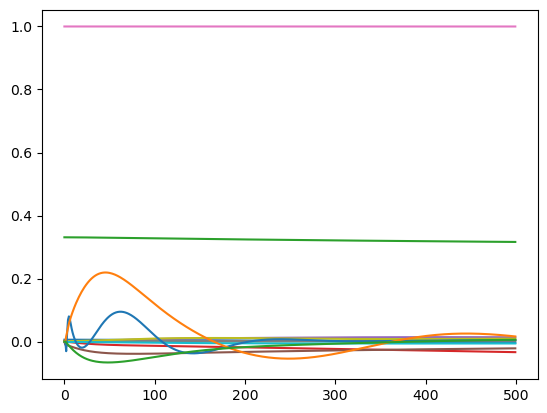

13-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7670>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7790>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7850>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7910>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b79d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7a90>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7b50>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7c10>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7cd0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7d90>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231f0040>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7eb0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2231b7fa0>

In [188]:
plot(xs)

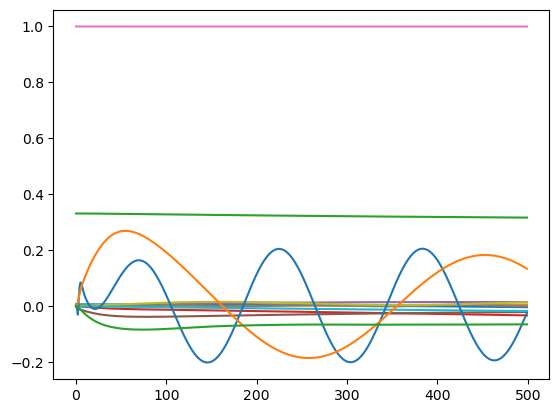

13-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494a60>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494b80>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494c40>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494d00>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494dc0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494e80>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494f40>
 PyObject <matplotlib.lines.Line2D object at 0x7fa223494fa0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2234a0100>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2234a01c0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2234e4280>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2234a02e0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa2234a03d0>

In [181]:
plot(xs)

In [2]:
function sum_inertia_properties(FA1, bodylist::Vector{String}, reference_frame)
    moment_sum = zeros(3,3)
    cross_part_sum = zeros(3)
    mass_sum = 0.

    for body_name in bodylist 
        body = findbody(FA1.rigidbody.mech, body_name)
        s = FA1.rigidbody.statecache[Float64]
        copyto!(s, x_eq)
        body_to_reference = relative_transform(s, body.inertia.frame, reference_frame)
        inertia_in_reference = transform(body.inertia, body_to_reference)

        ### Now we have the inertia properties relative to the trunk frame origin 
        ### let's sum them up
        cross_part_sum = cross_part_sum + inertia_in_reference.cross_part
        mass_sum += inertia_in_reference.mass
        moment_sum += inertia_in_reference.moment
    end 

    com = cross_part_sum/mass_sum 
    return com, moment_sum, mass_sum
end 

sum_inertia_properties (generic function with 1 method)

In [14]:
trunk_frame = findbody(A1.rigidbody.mech, "trunk").inertia.frame

CartesianFrame3D: "after_floating_base" (id = 63)

In [15]:
com3, moment3, mass3 = sum_inertia_properties(A1, ["trunk", "FR_hip", "FL_hip", "RR_hip", "RL_hip",
                                                            "FR_thigh", "FL_thigh", "RR_thigh", "RL_thigh"],trunk_frame)

([0.0, 0.0, 0.0], [0.027381187495917766 8.399593743400103e-5 -0.0047403198559239496; 8.399593743400103e-5 0.08036634614190742 2.519722365030061e-5; -0.00474031985592395 2.5197223650300607e-5 0.08584845337594753], 4.713)

In [16]:
com3

3-element StaticArrays.SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 0.0

In [17]:
moment3

3×3 StaticArrays.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  0.0273812   8.39959e-5  -0.00474032
  8.39959e-5  0.0803663    2.51972e-5
 -0.00474032  2.51972e-5   0.0858485

In [9]:
mass3

7.496999999999999